In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Classification_train.csv")

In [ ]:
dataset.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
target = dataset.iloc[:, 0]
features = dataset.iloc[:, 1:]

X = features.to_numpy()
y = target.to_numpy()

#scaling
X_n = X/255

# Splitting
test_size = 0.1

split_train = int(len(dataset) * (1 - 2 * test_size))
split_cv = int(len(dataset) * (1 - test_size))

X_train = X_n[:split_train].T
y_train = y[:split_train]

X_cv = X_n[split_train:split_cv].T
y_cv = y[split_train:split_cv]

X_test = X_n[split_cv:].T
y_test = y[split_cv:]

In [ ]:
def one_hot_encode(y):
    examples = len(y)
    one_hot_labels = np.zeros((examples, 10))

    for i in range(examples):
        label = y[i]
        one_hot_labels[i, label] = 1

    return one_hot_labels

y_train_one_hot = one_hot_encode(y_train).T
y_cv_one_hot = one_hot_encode(y_cv).T
y_test_one_hot = one_hot_encode(y_test) .T

print(y_train_one_hot.shape)

(10, 24000)


In [ ]:
def relu(x):
  return np.maximum(x, 0)
def der_relu(X):
  return np.array((X > 0).astype(int))
def softmax(X):
    X = X-np.max(X,axis=0,keepdims=True)
    return np.exp(X)/np.sum(np.exp(X),axis=0,keepdims=True)

In [ ]:
def predict(X,parameters):
  outputs = fwd_prop(X,parameters)
  l = int(len(parameters)/2)
  a_l = outputs["a" + str(l)]

  y_pred =np.argmax(a_l,axis=0)
  return y_pred

In [ ]:
def init_parameters(layers):
  np.random.seed(42)
  parameters = {}
  l = len(layers) - 1
  for i in range(l):
    parameters["W"+str(i+1)] = np.random.randn(layers[i+1] , layers[i])*0.01
    parameters["b"+str(i+1)] = np.zeros((layers[i+1],1))
  return parameters


In [ ]:
def compute_cost(a_l , y):
  cost = np.sum((-y * np.log(a_l)))
  return cost/y.shape[1]

In [ ]:
def fwd_prop(X , parameters):
  l = int(len(parameters)/2)
  outputs = {}

  outputs["z1"] = np.dot(parameters["W1"], X) + parameters["b1"]
  outputs["a1"] = relu(outputs["z1"])

  for i in range(2,l):
    outputs["z" + str(i)] = np.dot(parameters["W"+str(i)], outputs["a" + str(i-1)]) + parameters["b"+str(i)]
    outputs["a" + str(i)] = relu(outputs["z" + str(i)])

  outputs["z" + str(l)] = np.dot(parameters["W"+str(l)], outputs["a" + str(l-1)]) + parameters["b"+str(l)]
  outputs["a" + str(l)] = softmax(outputs["z" + str(l)])

  return outputs

In [ ]:
def back_prop(X, y, parameters, outputs):
  l =int(len(parameters)/2)
  gradients = {}
  m = X.shape[1]

  gradients["dz" + str(l)] = outputs["a" + str(l)] - y
  gradients["dw" + str(l)] = (1/m)*np.dot(gradients["dz" + str(l)] , outputs["a" + str(l-1)].T)
  gradients["db" + str(l)] = (1/m)*np.sum(gradients["dz" + str(l)] , axis =1 , keepdims = True)

  for i in reversed(range(2 ,l)):
    gradients["dz" + str(i)] = np.dot(parameters["W" + str(i+1)].T , gradients["dz" + str(i+1)])*der_relu(outputs["z" + str(i)])
    gradients["dw" + str(i)] = (1/m)*np.dot(gradients["dz" + str(i)] , outputs["a" + str(i-1)].T)
    gradients["db" + str(i)] = (1/m)*np.sum(gradients["dz" + str(i)], axis =1 , keepdims = True)

  gradients["dz1"] = np.dot(parameters["W2"].T , gradients["dz2"])*der_relu(outputs["z1"])
  gradients["dw1"] = (1/m)*np.dot(gradients["dz1"] , X.T)
  gradients["db1"] = (1/m)*np.sum(gradients["dz1"], axis =1 , keepdims = True)

  return gradients

In [ ]:
def gradient_descent(parameters, gradients ,alpha):
  l = int(len(parameters)/2)
  for i in range(l):
    parameters["W" + str(i+1)] -= alpha*gradients["dw" + str(i+1)]
    parameters["b" + str(i+1)] -= alpha*gradients["db" + str(i+1)]
  return  parameters

In [ ]:
def model(x ,y , alpha , layers , epochs , batchSize):

 J_history = []
 cost = 0
 parameters =  init_parameters(layers)

 initial_outputs = fwd_prop(x, parameters)
 initial_cost = compute_cost(initial_outputs["a" + str(len(layers) - 1)], y)
 print(f"Epoch {0}/{epochs}  , Cost  = {initial_cost}")

 for i in range(epochs):
   for j in range(int(x.shape[1] / batchSize)):
    x_mini     =  x[: , batchSize*(j) : batchSize*(j+1)]
    y_mini     =  y[: , batchSize*(j) : batchSize*(j+1)]
    outputs    =  fwd_prop(x_mini , parameters)
    cost       =  compute_cost(outputs["a" + str(len(layers)-1)], y_mini)
    gradients  =  back_prop(x_mini, y_mini , parameters , outputs)
    parameters =  gradient_descent(parameters, gradients, alpha)
   print(f"Epoch {i+1}/{epochs}  , Cost  = {cost}")
   J_history.append(cost)

 return parameters ,J_history

In [ ]:
layers = np.array([X_train.shape[0], 256 ,128 , 64 , y_train_one_hot.shape[0]])
parameters, J_history = model(X_train, y_train_one_hot, 0.1,layers , 30 , 32)

Epoch 0/30  , Cost  = 2.3025830353107035
Epoch 1/30  , Cost  = 2.304711228434165
Epoch 2/30  , Cost  = 2.304375634654444
Epoch 3/30  , Cost  = 1.3542888070012806
Epoch 4/30  , Cost  = 0.20158085184073965
Epoch 5/30  , Cost  = 0.033330226406077336
Epoch 6/30  , Cost  = 0.03181320766667123
Epoch 7/30  , Cost  = 0.018642270219693346
Epoch 8/30  , Cost  = 0.010314494952546218
Epoch 9/30  , Cost  = 0.0063671105746263175
Epoch 10/30  , Cost  = 0.011882482221460284
Epoch 11/30  , Cost  = 0.007551892548333177
Epoch 12/30  , Cost  = 0.0032751046975360984
Epoch 13/30  , Cost  = 0.0031767867800747444
Epoch 14/30  , Cost  = 0.0005321051335198499
Epoch 15/30  , Cost  = 0.0003536462518857795
Epoch 16/30  , Cost  = 0.0002675523810624679
Epoch 17/30  , Cost  = 0.00020718936815947663
Epoch 18/30  , Cost  = 0.00017996655589550724
Epoch 19/30  , Cost  = 0.0001225131674755138
Epoch 20/30  , Cost  = 9.891088218048051e-05
Epoch 21/30  , Cost  = 8.864036172442215e-05
Epoch 22/30  , Cost  = 7.504653720983445e

Text(0.5, 1.0, 'Cost vs Epochs')

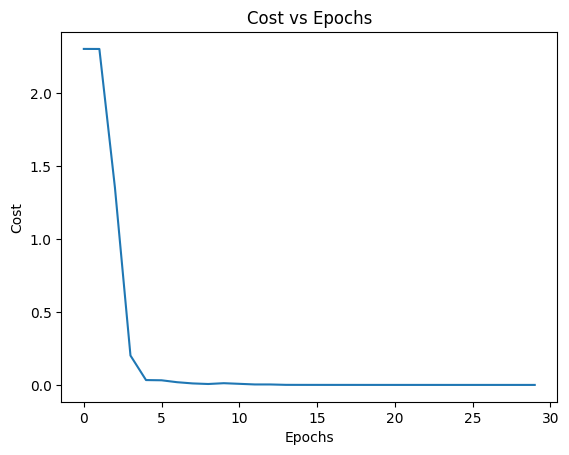

In [ ]:
plt.plot(range(0, 30) , J_history)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Cost vs Epochs")

In [ ]:
def calc_accuracy(y, y_pred):
    accuracy = np.sum(y == y_pred) / len(y)
    return accuracy


In [ ]:
y_pred_train = predict(X_train ,parameters)

accuracy = calc_accuracy(y_train ,  y_pred_train )

print(f"\nAccuracy on training set = {accuracy}")


Accuracy = 1.0


In [ ]:
y_pred_cv = predict(X_cv ,parameters)

accuracy = calc_accuracy(y_cv ,  y_pred_cv )

print(f"\nAccuracy on cv set = {accuracy}")


Accuracy = 0.9826666666666667


In [ ]:
y_pred_test = predict(X_test ,parameters)

accuracy = calc_accuracy(y_test ,  y_pred_test)

print(f"\nAccuracy on test set = {accuracy}")


Accuracy = 0.986


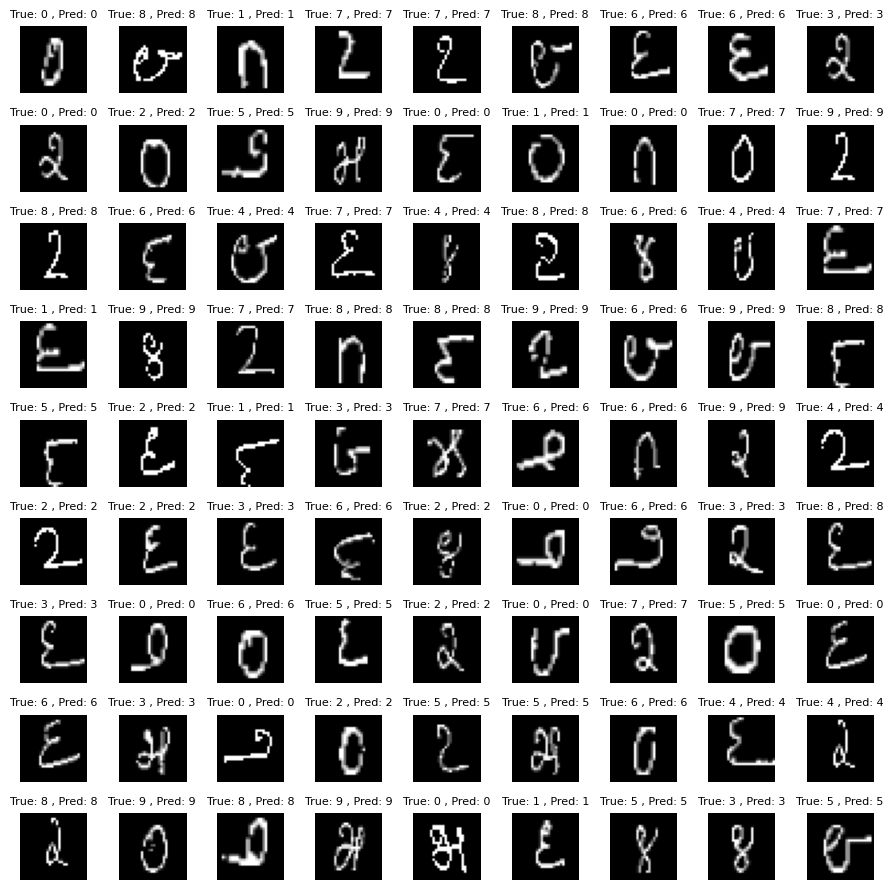

In [ ]:
pixels_train = (X_train.T*255).reshape(-1,28,28)
fig ,axes = plt.subplots(9 ,9 , figsize = (9,9))
for i in range(9):
  for j in range(9):
    axes[i , j].imshow(pixels_train[i*8 +j] , cmap = "gray")
    axes[i , j].axis("off")
    title = f'True: {y_train[i * 9 + j]} , Pred: {y_pred_train[i * 9 + j]}'
    axes[i, j].set_title(title , fontsize = 8)

plt.tight_layout()
plt.show()

In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/Classification_test.csv")
test_data.head()
X = test_data.to_numpy()
X = X / 255
y_predicted = predict(X , parameters)
print(y_predicted)